# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [70]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
from collections import defaultdict
import progressbar
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.externals import joblib

% matplotlib inline
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid')
% matplotlib inline



In [71]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


In [72]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [73]:
profile.shape


(17000, 5)

In [74]:
profile.isnull().sum()


age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

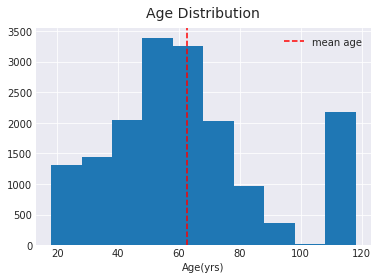

In [76]:
profile['age'].hist();
plt.axvline(profile['age'].mean(), color = 'red', linestyle = '--', label = 'mean age')
plt.title('Age Distribution', fontsize = 14, y = 1.02)
plt.xlabel('Age(yrs)')
plt.legend()
plt.show()

In [77]:
profile.age.describe()


count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [78]:
profile[profile['age'] > 90]['age'].value_counts()


118    2175
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
101       5
99        5
98        5
Name: age, dtype: int64

In [79]:
profile['age'].replace(118, np.nan, inplace = True)


# Income

In [80]:
profile.income.describe()


count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

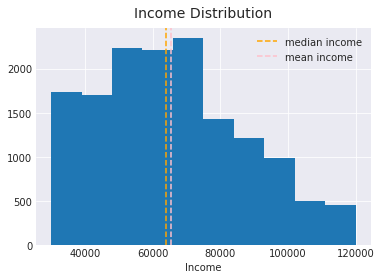

Median Income : 64000.0
Mean Income : 65405.0


In [81]:
profile['income'].hist();
plt.axvline(profile['income'].median(), color = 'orange', linestyle = '--', label = 'median income')
plt.axvline(profile['income'].mean(), color = 'pink', linestyle = '--', label = 'mean income')
plt.title('Income Distribution', fontsize = 14, y = 1.02)
plt.xlabel('Income')
plt.legend()
plt.show()

print('Median Income : {}'.format(profile['income'].median()))
print('Mean Income : {}'.format(round(profile['income'].mean(), 1)))

# Gender

In [82]:
profile['gender'].value_counts()/len(profile['gender'].dropna())*100


M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

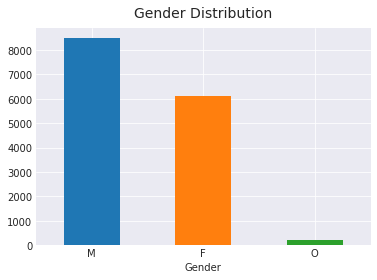

In [83]:
profile['gender'].value_counts().plot(kind='bar')
plt.xticks(rotation = 0)
plt.title('Gender Distribution', fontsize = 14, y = 1.02)
plt.xlabel('Gender')
plt.show()

In [84]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')


In [85]:
profile['member_since_year'] = profile['became_member_on'].dt.year


In [86]:
profile['member_for_days'] = pd.to_datetime('20180926',format='%Y%m%d')
profile['member_for_days'] = round(((profile['member_for_days'] - profile['became_member_on'])/np.timedelta64(1, 'D')))

In [87]:
profile.head()


,age,became_member_on,gender,id,income,member_since_year,member_for_days
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,591.0
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,438.0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,76.0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,505.0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,418.0


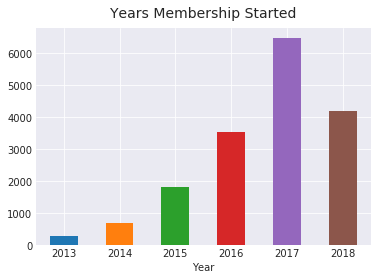

In [88]:
profile.groupby('member_since_year').count()['id'].plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.title('Years Membership Started', fontsize = 14, y = 1.02)
plt.xlabel('Year')
plt.show()

In [89]:
profile.sort_values(by = 'became_member_on').tail(1)


,age,became_member_on,gender,id,income,member_since_year,member_for_days
4357,76.0,2018-07-26,M,6597e5ab63754726b83ba2032f008d26,92000.0,2018,62.0


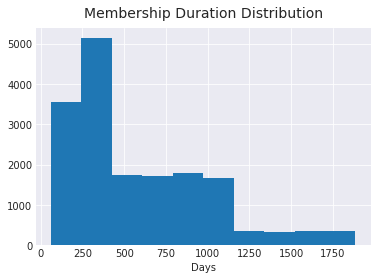

In [90]:
profile['member_for_days'].hist()
plt.title('Membership Duration Distribution', fontsize = 14, y = 1.02)
plt.xlabel('Days')
plt.show()

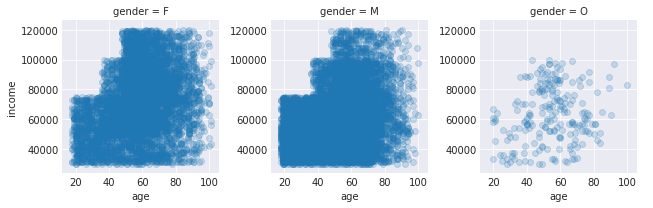

In [92]:
g = sns.FacetGrid(data = profile, col = 'gender')
g.map(plt.scatter, 'age', 'income', alpha=0.2);
g.add_legend();

In [23]:
profile.head()


,age,became_member_on,gender,id,income,member_since_year,member_for_days
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,591.0
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,438.0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,76.0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,505.0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,418.0


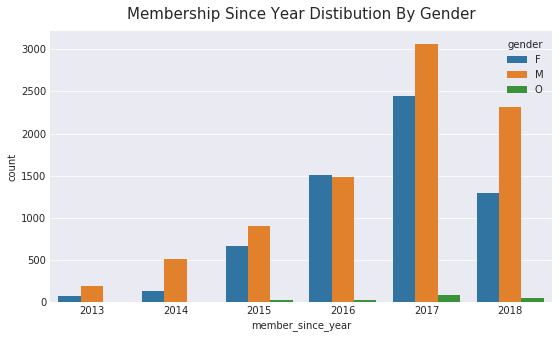

In [93]:

plt.figure(figsize=(9, 5))
mem_since_plot = sns.countplot(data = profile, x = 'member_since_year', hue = 'gender')
mem_since_plot.set_title('Membership Since Year Distibution By Gender', fontsize = 15, y = 1.02);

### Findings of Preliminary Exploration Of The Profile Dataset
* Most of the users are from an older generation.
* Most users became members in recent years.
* Median income of the user base is $64k.
* Males make up 57% of the user base while females make up 41%.

## Exploratory Data Analysis : Portfolio

In [94]:
portfolio


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [95]:
portfolio['offer_name'] = portfolio['offer_type'] + '_' + portfolio['difficulty'].astype(str) + '_' + portfolio['reward'].astype(str) + '_' + portfolio['duration'].astype(str)


In [96]:
ohe_channels = portfolio['channels'].str.join(',').str.get_dummies(',')
portfolio = pd.concat([portfolio, ohe_channels], axis = 1)
portfolio.drop(['channels'], axis = 1, inplace = True)

In [97]:
portfolio['offer_type'].value_counts()


bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

# Exploratory Data Analysis - Transcript

In [98]:
transcript.shape


(306534, 4)

In [99]:
transcript.isnull().sum()


event     0
person    0
time      0
value     0
dtype: int64

In [100]:
transcript.head()


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


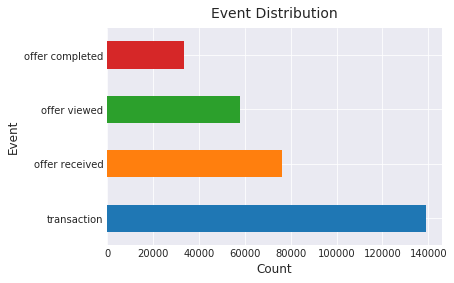

In [101]:
transcript['event'].value_counts().plot(kind = 'barh')
plt.title('Event Distribution', fontsize = 14, y = 1.02)
plt.ylabel('Event', fontsize= 12)
plt.xlabel('Count', fontsize= 12)
plt.show()

In [102]:
profile.dropna(inplace = True)


In [103]:
profile.rename(columns = {'id' : 'person'}, inplace = True)


In [104]:

transcript['trans_amount'] = 0
transcript['offer_id'] = np.nan

In [105]:
def return_trans_amount(dic):
    if 'amount' in dic.keys():
        return dic['amount']
    else:
        return 0

def return_offer_id(dic):
    if 'offer id' in dic.keys():
        return dic['offer id']
    elif 'offer_id' in dic.keys():
        return dic['offer_id']
    else:
        return np.nan

In [106]:
transcript['trans_amount'] = transcript['value'].apply(lambda x: return_trans_amount(x))
transcript['offer_id'] = transcript['value'].apply(lambda x: return_offer_id(x))

In [107]:
portfolio.rename(columns = {'id' : 'offer_id'}, inplace = True)


In [108]:
transcript = transcript.merge(portfolio, how = 'left', on = 'offer_id')


In [109]:
transcript.drop(['value'], inplace = True, axis = 1)


In [110]:
transcript.head()


,event,person,time,trans_amount,offer_id,difficulty,duration,offer_type,reward,offer_name,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,7.0,bogo,5.0,bogo_5_5_7,1.0,1.0,0.0,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20.0,10.0,discount,5.0,discount_20_5_10,1.0,0.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,10.0,7.0,discount,2.0,discount_10_2_7,1.0,1.0,0.0,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,discount,2.0,discount_10_2_10,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,5.0,bogo,10.0,bogo_10_10_5,1.0,1.0,1.0,1.0


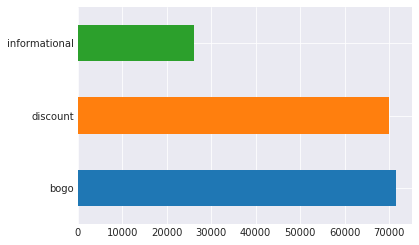

In [111]:
transcript['offer_type'].value_counts().plot(kind = 'barh');


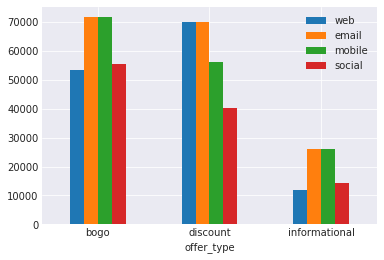

In [112]:
transcript.groupby('offer_type')['web', 'email', 'mobile', 'social'].sum().plot(kind = 'bar')
plt.xticks(rotation = 0)

plt.show()

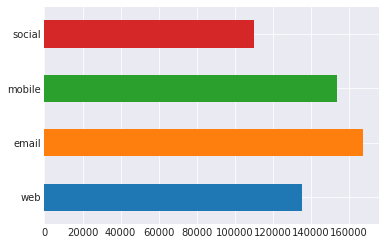

In [113]:
transcript[['web', 'email', 'mobile', 'social']].sum().plot('barh');


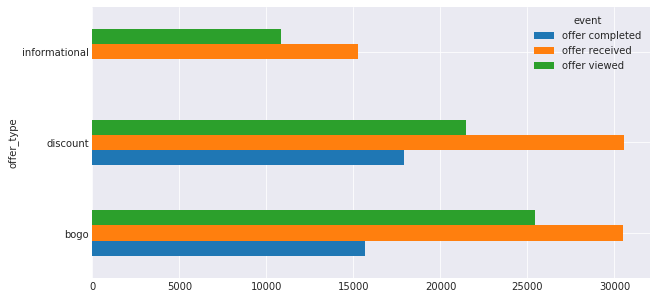

In [114]:
transcript.groupby(['event', 'offer_type'])['offer_type'].count().unstack(0).plot.barh(figsize = (10,5))


In [115]:
transcript = transcript.sort_values(['person', 'time'])


In [116]:
trans_viewed = transcript[(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].sort_values(['person', 'time']).fillna(method = 'ffill')


In [117]:
transcript.loc[trans_viewed.index] = trans_viewed


In [118]:
transcript.reset_index(inplace = True, drop = True)


In [119]:

cols = portfolio['offer_id'].tolist()
new_df1 = pd.DataFrame(np.nan, index = profile['person'].tolist(), columns = cols)
cols_new = ['trans_for_offer','trans_count','trans_total']
new_df2 = pd.DataFrame(np.zeros((profile.shape[0], 3)), index = profile['person'].tolist(), columns = cols_new)
profile_trans = pd.concat([new_df1, new_df2], axis = 1)

In [120]:
def get_trans_recs(person):
    
    '''Fetches transaction records from transcript dataset for 
    a particular user.
    
    INPUT:
        person (str): id of user
    OUTPUT:
        trans_recs (dataframe): transaction record for the particular user
    '''
    
    trans_recs = transcript[transcript['person'] == person].reset_index(drop=True)
    
    return trans_recs

In [121]:

bogo_discount_offer_ids = portfolio[portfolio['offer_type'].isin(['bogo', 'discount'])]['offer_id'].values

cnter = 0
pbar = progressbar.ProgressBar(maxval=profile_trans.shape[0], widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

for person_ind in range(profile_trans.shape[0]):
    cnter+=1 
    pbar.update(cnter)
    
    person = profile_trans.index[person_ind]
    trans_recs = get_trans_recs(person)
    offer_view_count = defaultdict(int)
    offer_comp_count = defaultdict(int)
    off_rec_ind = trans_recs[trans_recs['event'] == 'offer received'].index.values
    transactions = trans_recs[trans_recs.event == 'transaction']
    profile_trans.loc[person, 'trans_count'] = transactions.shape[0]
    profile_trans.loc[person, 'trans_total'] = transactions['trans_amount'].sum()

    trans_off_ind = []
    
    for r_i in off_rec_ind:
        offer_id = trans_recs.loc[r_i, 'offer_id']
        offer_valid_for = int(portfolio[portfolio['offer_id'] == offer_id]['duration']) * 24
        offer_start = trans_recs.loc[r_i, 'time']
        offer_end = offer_start + offer_valid_for
        
        viewed = trans_recs[(trans_recs['offer_id'] == offer_id) &
                           (trans_recs['event'] == 'offer viewed') &
                           (trans_recs['time'] >= offer_start) &
                           (trans_recs['time'] <= offer_end)]
        
        if viewed.shape[0] < 1:
            continue
        
        else:
            if offer_id in bogo_discount_offer_ids:
                completed = trans_recs[(trans_recs['offer_id'] == offer_id) &
                           (trans_recs['event'] == 'offer completed') &
                           (trans_recs['time'] >= offer_start) &
                           (trans_recs['time'] <= offer_end)]
                if completed.shape[0] < 1 :
                    offer_view_count[offer_id] += 1
                    offer_comp_count[offer_id] += 0
                else:
                    view_ind = viewed.index[0]
                    comp_ind = completed.index[0]
                    if view_ind < comp_ind:
                        offer_view_count[offer_id] += 1
                        offer_comp_count[offer_id] += 1
                        trans_off_ind.extend(transactions.loc[view_ind:comp_ind].index.values)
                    else:
                        continue
            else:
                view_time = viewed.iloc[0]['time']
                offer_view_count[offer_id] +=1
                info_trans = trans_recs[(trans_recs['event'] == 'transaction') &
                                       (trans_recs['time'] >= view_time) &
                                       (trans_recs['time'] <= offer_end)]
                if info_trans.shape[0] > 0:
                    offer_comp_count[offer_id] += 1
                else:
                    offer_comp_count[offer_id] += 0
    
    for off_id in offer_view_count.keys():
        profile_trans.loc[person, off_id] = offer_comp_count[off_id]/offer_view_count[off_id]
        
    if len(trans_off_ind) > 0:
        profile_trans.loc[person, 'trans_for_offer'] = transactions.loc[list(set(trans_off_ind))]['trans_amount'].sum()

In [122]:
profile_trans['avg_trans'] = (profile_trans['trans_total']/profile_trans['trans_count'] + 0.001)
profile_trans['trans_offer_ratio'] = (profile_trans['trans_for_offer']/profile_trans['trans_total'] + 0.001)
profile_trans.drop(['trans_for_offer', 'trans_count'], inplace=True, axis=1)

In [123]:
profile.set_index(['person'], inplace=True, drop=True)
profile.index.name = None

In [124]:
profile_trans = profile_trans.join(profile)


In [125]:
profile_trans.to_csv('profile_trans.csv')


In [126]:
profile_trans.head()


,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,trans_total,avg_trans,trans_offer_ratio,age,became_member_on,gender,income,member_since_year,member_for_days
0610b486422d4921ae7d2bf64640c50b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.01,25.671000,0.001000,55.0,2017-07-15,F,112000.0,2017,438.0
78afa995795e4d85b5d9ceeca43f5fef,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,159.27,22.753857,0.262254,75.0,2017-05-09,F,100000.0,2017,505.0
e2127556f4f64592b11af22de27a7932,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,0.0,57.73,19.244333,0.320072,68.0,2018-04-26,M,70000.0,2018,153.0
389bc3fa690240e798340f5a15918d5c,NaN,NaN,NaN,0.5,NaN,NaN,1.0,NaN,1.0,1.0,36.43,12.144333,1.001000,65.0,2018-02-09,M,53000.0,2018,229.0
2eeac8d8feae4a8cad5a6af0499a211d,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,15.62,3.906000,0.796775,58.0,2017-11-11,M,51000.0,2017,319.0


In [127]:
profile_trans = pd.read_csv('profile_trans.csv', index_col= 'Unnamed: 0')
profile_trans.index.name = None

In [128]:
offer_ids = portfolio.offer_id.tolist()
offer_names = portfolio.offer_name.tolist()
offer_dict = {}
for i,v in enumerate(offer_ids):
    offer_dict[v] = offer_names[i]

In [129]:
profile_trans.rename(offer_dict, axis = 1, inplace=True)
profile_trans.tail()

,bogo_10_10_7,bogo_10_10_5,informational_0_0_4,bogo_5_5_7,discount_20_5_10,discount_7_3_7,discount_10_2_10,informational_0_0_3,bogo_5_5_5,discount_10_2_7,trans_total,avg_trans,trans_offer_ratio,age,became_member_on,gender,income,member_since_year,member_for_days
6d5f3a774f3d4714ab0c092238f3a1d7,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,20.03,2.862429,0.001000,45.0,2018-06-04,F,54000.0,2018,114.0
2cb4f97358b841b9a9773a7aa05a9d77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,25.97,3.711000,0.001000,61.0,2018-07-13,M,72000.0,2018,75.0
01d26f638c274aa0b965d24cefe3183f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,39.74,4.968500,0.001000,49.0,2017-01-26,M,73000.0,2017,608.0
9dc1421481194dcd9400aec7c9ae6366,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.67,13.548857,0.107712,83.0,2016-03-07,F,50000.0,2016,933.0
e4052622e5ba45a8b96b59aba68cf068,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,143.02,23.837667,0.151678,62.0,2017-07-22,F,82000.0,2017,431.0


#Exploratory Data Analysis: Transactions and Profiles

In [130]:
profile_trans[['age', 'income', 'member_for_days', 'trans_total', 'avg_trans', 'trans_offer_ratio']].describe()

,age,income,member_for_days,trans_total,avg_trans,trans_offer_ratio
count,14825.000000,14825.000000,14825.000000,14825.000000,14492.000000,14492.000000
mean,54.393524,65404.991568,584.478988,117.028155,15.253287,0.266192
std,17.383705,21598.299410,419.205158,129.965016,16.543371,0.237455
min,18.000000,30000.000000,62.000000,0.000000,0.151000,0.001000
25%,42.000000,49000.000000,270.000000,31.450000,3.891833,0.027994
50%,55.000000,64000.000000,420.000000,87.040000,14.312214,0.237432
75%,66.000000,80000.000000,859.000000,160.900000,21.468625,0.401444
max,101.000000,120000.000000,1885.000000,1608.690000,451.471000,1.001000


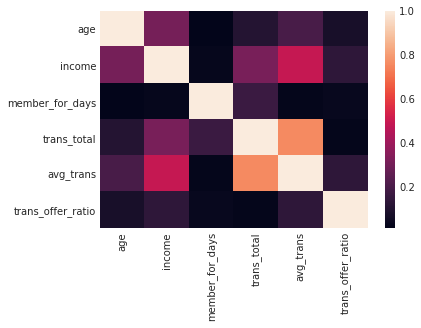

In [131]:
sns.heatmap(profile_trans[['age', 'income', 'member_for_days', 'trans_total', 'avg_trans', 'trans_offer_ratio']].corr());

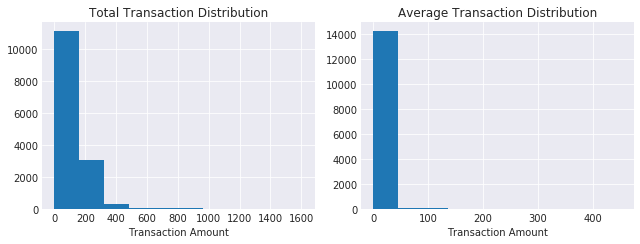

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(9,3.5))
profile_trans['trans_total'].hist(ax = axes[0]);
axes[0].set_title('Total Transaction Distribution')
axes[0].set_xlabel('Transaction Amount',)
profile_trans['avg_trans'].hist(ax = axes[1]);
axes[1].set_title('Average Transaction Distribution')
axes[1].set_xlabel('Transaction Amount')
plt.tight_layout()
plt.show()

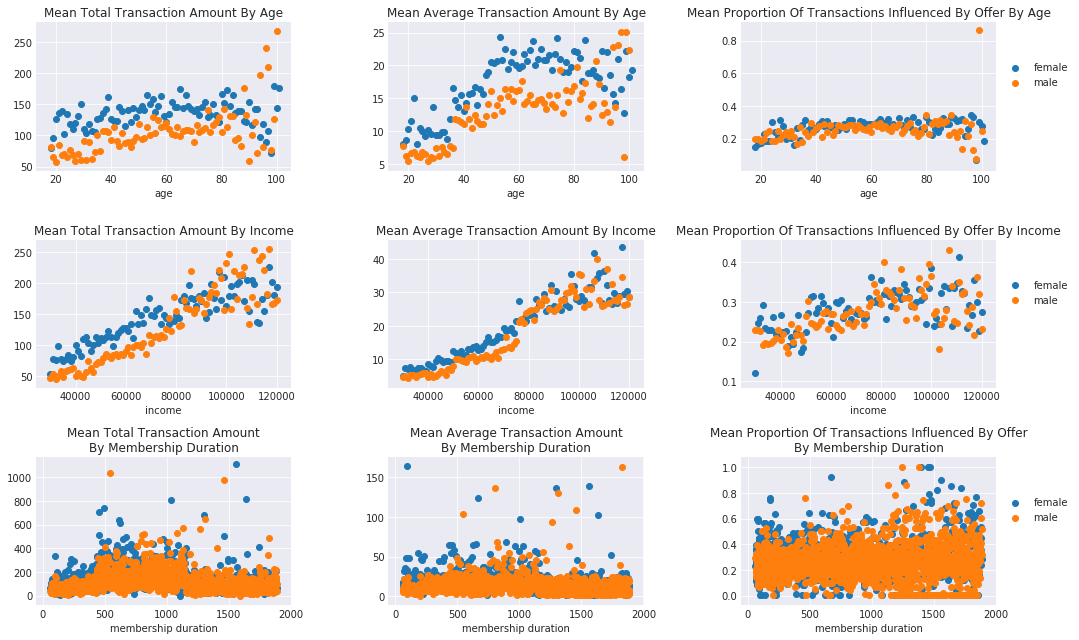

In [133]:

fig = plt.figure(figsize=(15,9))

plt.subplot(3,3,1)
female_avg = profile_trans[profile_trans.gender=='F'].groupby('age').mean()['trans_total']
male_avg = profile_trans[profile_trans.gender=='M'].groupby('age').mean()['trans_total']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('age');
plt.title('Mean Total Transaction Amount By Age')


plt.subplot(3,3,2)
female_avg = profile_trans[profile_trans.gender=='F'].groupby('age').mean()['avg_trans']
male_avg = profile_trans[profile_trans.gender=='M'].groupby('age').mean()['avg_trans']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('age');
plt.title('Mean Average Transaction Amount By Age')

plt.subplot(3,3,3)
female_avg = profile_trans[profile_trans.gender=='F'].groupby('age').mean()['trans_offer_ratio']
male_avg = profile_trans[profile_trans.gender=='M'].groupby('age').mean()['trans_offer_ratio']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('age');
plt.title('Mean Proportion Of Transactions Influenced By Offer By Age')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.subplot(3,3,4)
female_avg = profile_trans[profile_trans.gender=='F'].groupby('income').mean()['trans_total']
male_avg = profile_trans[profile_trans.gender=='M'].groupby('income').mean()['trans_total']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('income');
plt.title('Mean Total Transaction Amount By Income')


plt.subplot(3,3,5)
female_avg = profile_trans[profile_trans.gender=='F'].groupby('income').mean()['avg_trans']
male_avg = profile_trans[profile_trans.gender=='M'].groupby('income').mean()['avg_trans']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('income');
plt.title('Mean Average Transaction Amount By Income')

plt.subplot(3,3,6)
female_avg = profile_trans[profile_trans.gender=='F'].groupby('income').mean()['trans_offer_ratio']
male_avg = profile_trans[profile_trans.gender=='M'].groupby('income').mean()['trans_offer_ratio']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('income');
plt.title('Mean Proportion Of Transactions Influenced By Offer By Income')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

plt.subplot(3,3,7)
female_avg = profile_trans[profile_trans.gender=='F'].groupby('member_for_days').mean()['trans_total']
male_avg = profile_trans[profile_trans.gender=='M'].groupby('member_for_days').mean()['trans_total']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('membership duration');
plt.title('Mean Total Transaction Amount\nBy Membership Duration')


plt.subplot(3,3,8)
female_avg = profile_trans[profile_trans.gender=='F'].groupby('member_for_days').mean()['avg_trans']
male_avg = profile_trans[profile_trans.gender=='M'].groupby('member_for_days').mean()['avg_trans']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('membership duration');
plt.title('Mean Average Transaction Amount\nBy Membership Duration')

plt.subplot(3,3,9)
female_avg = profile_trans[profile_trans.gender=='F'].groupby('member_for_days').mean()['trans_offer_ratio']
male_avg = profile_trans[profile_trans.gender=='M'].groupby('member_for_days').mean()['trans_offer_ratio']
plt.scatter(female_avg.index, female_avg);
plt.scatter(male_avg.index, male_avg);
plt.xlabel('membership duration');
plt.title('Mean Proportion Of Transactions Influenced By Offer\nBy Membership Duration')
plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);



plt.tight_layout()
plt.show()

## Predicting The Best Offer For A User


In [134]:
profile_trans.head()


,bogo_10_10_7,bogo_10_10_5,informational_0_0_4,bogo_5_5_7,discount_20_5_10,discount_7_3_7,discount_10_2_10,informational_0_0_3,bogo_5_5_5,discount_10_2_7,trans_total,avg_trans,trans_offer_ratio,age,became_member_on,gender,income,member_since_year,member_for_days
0610b486422d4921ae7d2bf64640c50b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.01,25.671000,0.001000,55.0,2017-07-15,F,112000.0,2017,438.0
78afa995795e4d85b5d9ceeca43f5fef,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,159.27,22.753857,0.262254,75.0,2017-05-09,F,100000.0,2017,505.0
e2127556f4f64592b11af22de27a7932,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,0.0,57.73,19.244333,0.320072,68.0,2018-04-26,M,70000.0,2018,153.0
389bc3fa690240e798340f5a15918d5c,NaN,NaN,NaN,0.5,NaN,NaN,1.0,NaN,1.0,1.0,36.43,12.144333,1.001000,65.0,2018-02-09,M,53000.0,2018,229.0
2eeac8d8feae4a8cad5a6af0499a211d,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,15.62,3.906000,0.796775,58.0,2017-11-11,M,51000.0,2017,319.0


In [135]:
one_hot = pd.get_dummies(profile_trans['gender'])
profile_trans = profile_trans.drop('gender',axis = 1)
profile_trans = profile_trans.join(one_hot)

In [139]:
def train_test_data(col, df):
    
    '''Filters data for user with 1 or 0 for a particular offer and then splits it into training and testing sets.
    
    INPUT:
        col (str): offer id
        df (dataframe):profile_trans dataframe
    OUTPUT:
        xtrain : training dataset (features)
        xtest : testing dataset (features)
        ytrain : training dataset (labels)
        ytest : testing dataset (labels)
    '''
    
    data = df[(df.loc[:, col] == 1) | 
              (df.loc[:, col] == 0)].loc[:, ['age','income','F','M','O', 'member_for_days', col]]
    
    x = data.iloc[:, 0:6]
    y = data.iloc[:,-1]
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.10, random_state=36)
    
    return xtrain, xtest, ytrain, ytest

In [140]:
def train_grd_srch_cv(xtrain, xtest, ytrain, ytest):
    
    '''Performs and gridsearch and cross validation for a random forest classifier, fits it with the training data,
    makes predictions using the best estimator and then calculates the f1 score
    
    INPUT:
        xtrain : training dataset (features)
        xtest : testing dataset (features)
        ytrain : training dataset (labels)
        ytest : testing dataset (labels)
    OUTPUT:
        grd_clf(sklearn model instance) : trained model
        f1 (int) : f1 score of the model
    '''
    
    rf_clf = RandomForestClassifier()
    param_grid = {'bootstrap': [True],
                  'max_depth': [80, 90, 100, 110],
                  'max_features': [2, 3],
                  'min_samples_leaf': [3, 4, 5],
                  'min_samples_split': [8, 10, 12],
                  'n_estimators': [100, 200, 300, 1000]}

    grd_clf = GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
    grd_clf.fit(xtrain, ytrain)
    pred = grd_clf.predict(xtest)
    f1 = f1_score(ytest, pred)
    
    return grd_clf, f1

In [ ]:
offers = list(offer_dict.values())
models = []
f1s = []

cnter = 0
pbar = progressbar.ProgressBar(maxval=len(offers), widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

for i, off in enumerate(offers):
    cnter+=1 
    pbar.update(cnter)
    print('Training model for offer {}..'.format(i+1))
    xtrain, xtest, ytrain, ytest = train_test_data(off, profile_trans)
    grd_clf, f1 = train_grd_srch_cv(xtrain, xtest, ytrain, ytest)
    joblib.dump(grd_clf, 'model_'+str(i+1)+'.model')
    models.append(grd_clf)
    f1s.append(f1)
    print('Finished training model for offer {}. F1 score: {}\n'.format(i+1, f1))

pbar.finish()

Training model for offer 1..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 21.2min finished


Finished training model for offer 1. F1 score: 0.7271305707584051

Training model for offer 2..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 22.4min finished


Finished training model for offer 2. F1 score: 0.7063253012048193

Training model for offer 3..
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

In [ ]:
f1s

In [ ]:
models = []
for i in range(10):
    model_name = 'model_' + str(i)
    locals()[model_name] = joblib.load('model_'+str(i+1)+'.model')
    models.append(locals()[model_name])

In [ ]:

def prepare_input(age, income, gender, member_for_days):
    
    ''' Prepares user data such that it can be used as an input for the model.
    
    INPUT:
        age (int): age of the user
        income (float): income of the user
        gender(str): gender of the user. 'F' for female, 'M' for male, 'O' for other
        member_for_days (int) : number of days the user has been a member
    OUTPUT:
        inpt (numpy array) : numpy array containing user data
    '''
    
    genders = {'F': [1, 0, 0], 'M': [0, 1, 0], 'O': [0, 0, 1]}
    inpt = [age, income]
    inpt.extend(genders[gender])
    inpt.extend([member_for_days])
    inpt = np.array(inpt).reshape(1,-1)
    return inpt

In [ ]:
def predict_best_offers(age, income, gender, member_for_days, models, n):
    
    '''
    Calculates the probability of an offer being effective and returns the names of the best n offers for a user
    
    INPUT:
        age (int): age of the user
        income (float): income of the user
        gender(str): gender of the user. 'F' for female, 'M' for male, 'O' for other
        member_for_days (int) : number of days the user has been a member
        models (list) : list of models for each offer, used to calculate the probability
        n (int) : number of best offer names required
    OUTPUT:
        top_offers (list) : list of n best offers for the user
    '''
    
    user_data = prepare_input(age, income, gender, member_for_days)
    pred_probs = []
    for i in range(10):
        prob = models[i].predict_proba(user_data)[0][1]
        pred_probs.append(prob)
    offer_probs = pd.DataFrame(pred_probs, index = list(offer_dict.values()), columns=['prob'])
    offer_probs.sort_values(ascending=False, by = 'prob', inplace = True)
    top_offers = offer_probs.index.tolist()
    
    return top_offers[0:n]

In [ ]:
predict_best_offers(25, 45000, 'M', 1, models, 3)


In [ ]:
xx.sort_values(ascending=False, by = 'prob', inplace = True)


In [ ]:

imps = models[0].best_estimator_.feature_importances_
labels = ['age','income','F','M','O', 'member_for_days']
xx = pd.DataFrame(imps, index= labels, columns= ['importance'])
xx.sort_values(by = 'importance').plot(kind = 'barh')
plt.show()

In [ ]:
def regression_grid_search(profile_trans):
    
    '''Performs gridsearch and cross validation of the regression model and fits them on the training data.
    INPUT:
        profile_trans (dataframe) : profile
    OUTPUT:
        gcv_rmodel (sklearn model instance) - trained  model
    '''
    
    data = profile_trans.loc[:,['age', 'income', 'F', 'M', 'O', 'member_for_days', 'avg_trans', 'trans_offer_ratio']]
    x = data.iloc[:,0:6]
    y = data.iloc[:,-2:]
    rmodel = RandomForestRegressor()
    
    param_grid = {'bootstrap': [True],
                  'max_depth': [80, 90, 100, 110],
                  'max_features': [2, 3],
                  'min_samples_leaf': [3, 4, 5],
                  'min_samples_split': [8, 10, 12],
                  'n_estimators': [100, 200, 300, 1000]}
    
    scoring = {'R2': 'r2', 'EV': 'explained_variance'}
    
    gcv_rmodel = GridSearchCV(rmodel, param_grid, scoring = scoring, refit = 'R2', cv=5, return_train_score=False)
    gcv_rmodel.fit(x, y)
    joblib.dump(gcv_rmodel, 'rmodel.model')
  
    return gcv_rmodel

In [ ]:
rmodel = regression_grid_search(profile_trans.dropna(subset=['avg_trans'], axis=0))


In [ ]:
imps = rmodel.best_estimator_.feature_importances_
labels = ['age','income','F','M','O', 'member_for_days']
xx = pd.DataFrame(imps, index= labels, columns= ['importance'])
xx.sort_values(by = 'importance').plot(kind = 'barh')
plt.show()

In [ ]:
def pred_trans_influence(age, income, gender, member_for_days, rmodel):
    
    '''Predicts the total transactions made by the user and the proportion of transaction that is influenced by
    offer based on input data.
    
    INPUT:
        age (int): age of the user
        income (float): income of the user
        gender(str): gender of the user. 'F' for female, 'M' for male, 'O' for other
        member_for_days (int) : number of days the user has been a member
        rmodel (sklearn model instance) : trained regression model
    OUTPUT:
        preds (list) : a list where the first element is the total transactions made by the user and 
                       the second element is the proportion of transaction that is influenced by offer
    '''
    user_data = prepare_input(age, income, gender, member_for_days)
    preds = rmodel.predict(user_data)
    
    return preds.tolist()[0]

In [ ]:
def pred_offer_trans(age, income, gender, member_for_days, n, models, rmodel):
    
    '''Prints the best n offers for a user along with the predicting transaction of the user and 
       the proportion of the transaction influenced by offer
       
        INPUT:
            age (int): age of the user
            income (float): income of the user
            gender(str): gender of the user. 'F' for female, 'M' for male, 'O' for other
            member_for_days (int) : number of days the user has been a member
            n (int) : number of best offer names required
            models (list) : list of models for each offer, used to calculate the probability
            rmodel (sklearn model instance) : trained regression model
        OUTPUT:
            N/A
           
    '''
    top_offers = predict_best_offers(age, income, gender, member_for_days, models, n)
    trans_infl = pred_trans_influence(age, income, gender, member_for_days, rmodel)
    print('The best offers for this user are:')
    for i in top_offers:
        print(i)
    print('\n')
    
    print('This user will have a transaction of ${} and {}% of it will be influenced by offer.'.format(round(trans_infl[0], 2), round(trans_infl[1]*100, 2)))

In [ ]:
pred_offer_trans(25, 65000, 'M', 19, 3, models, rmodel)


### Discussion
Model Performance
Classification Models

Of all the models here, the lowest, 0.72, was for bogo_10_10_7 and the highest, 0.85, was for discount_10_2_10. Although the models did not have extremely high f1 scores, as none of them had a score below 0.70, for the purposes of this particular project, they can be deemed satisfactory. However, there is plenty of room for improvements, which will be discussed later on in this section.

Regression Model

The regression model performed poorly, with a very low R2 score. This could be because the amount a person spends is complex and multidimensional, so it is very difficult to explain a very big amount of variation. Furthermore, we only had four features we could use to predict it.

Project Limitations & Shortcomings
Limited computational power together with time restrictions meant that the hyperparameters of the models could not be tuned as thoroughly. This may have contributed to the relatively low score achieved by the regression model.